# What & Why
This notebook is inspired by the [second part](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) of Jeremy's solution of [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) competition.

It explores effects of
* speed up from working on smaller image sizes
* using more recent model architecture (ConvxNet)
* exploring impact of augmentation during training
* test time augmentation

# Python packages setup & data download

This part is copied from the [01-baseline.ipynb](./01-baseline.ipynb)

In [1]:
USE_LATEST_PIP_PACKAGES = True

In [2]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    print("Running notebook in kaggle mode")
else:
    print("Running notebook in Paperspace mode")

Running notebook in Paperspace mode


In [3]:
# install Jeremy's fastkaggle package with helpers for Kaggle API
try:
    import fastkaggle
except ModuleNotFoundError:
    if is_kaggle:
        print("installing fastkaggle into system folder on Kaggle")
        !pip install -q fastkaggle
    else:
        print("installing fastkaggle into user (/root/.local/) folder on Paperspace")
        # we are installing into local folder
        !pip install --user -q fastkaggle

from fastkaggle import setup_comp, push_notebook

In [4]:
# Jeremy's philosophy is to always work on latest versions of all packages 
# and don't bother with creating and tracking Python environments with the fixed set of packages
# I still like to have full replica of the env, so plan to add it as a fallback
if not is_kaggle:
    if USE_LATEST_PIP_PACKAGES:
        !pip install --user -Uqq timm huggingface_hub fastai
    else:
        !pip install --user  --no-cache-dir -r ../requirements.txt

## Get competition data

In [5]:
# setup_comp downloads competition dataset archive into the current folder and extracts into subfolder
# it also pip-installs libraries when if we are on Kaggle
COMPETITION_NAME = 'paddy-disease-classification'

path = setup_comp(COMPETITION_NAME, install='timm huggingface_hub fastai')

In [64]:
import pandas as pd

In [6]:
# import fastai only after we updated all packages on Kaggle or locally
from fastai.vision.all import *
from fastcore.parallel import *
set_seed(42)

In [7]:
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

# Quick look at data

In [8]:
train_path = path / "train_images"

In [9]:
train_files = get_image_files(train_path)

File:  paddy-disease-classification/train_images/tungro/100723.jpg
Size:  (480, 640)


<AxesSubplot:>

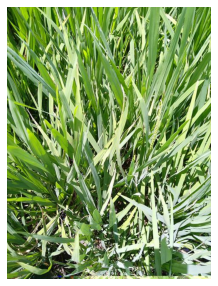

In [10]:
# show single file
idx = 2002
img = PILImage.create(train_files[idx])
print("File: ", train_files[idx])
print("Size: ", img.size)
img.show()

In [11]:
%%time
def get_image_size(file_path):
    return PILImage.create(file_path).size

assert get_image_size(train_files[0]) == (480, 640)


sizes = parallel(get_image_size, train_files, n_workers=8)
pd.Series(sizes).value_counts()

CPU times: user 6.77 s, sys: 1.82 s, total: 8.6 s
Wall time: 43.6 s


(480, 640)    10403
(640, 480)        4
dtype: int64

# Helpers to train the model

In [13]:
def train(train_path, model_arch, item_transforms, batch_transforms, n_epochs):
    dls = ImageDataLoaders.from_folder(
        train_path, 
        valid_pct=0.2, 
        seed=42, 
        item_tfms=item_transforms,
        batch_tfms=batch_transforms,
    )
    learn = vision_learner(dls, model_arch, metrics=error_rate, path='.').to_fp16()
    learn.fine_tune(n_epochs, 0.01) #we use Lr selecte in the previous notebook usign learn.lr_find
    return learn, dls

# 1. Resnet, experiment with resizing

We couldn't train without resizing because we have 4 examples with different aspect ratios. 
The following code fails because DataLoader couldn't create a batch from images of different shapes:
```
learn, dls = train(train_path, "resnet26d", None, None, 3)
```

*Error:*
```
RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 640, 480])
	Item at index 24 has shape: torch.Size([3, 480, 640])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size
```

## 1.1 Resize to 20% of original size, No batch augmentation

In [44]:
%%time
# the order of dimensions is different from PIL:
#   number of rows is the first element in the tuple for tensors but second for PIL.
learn, dls = train(train_path, "resnet26d", Resize((128, 96)), None, 3)

epoch,train_loss,valid_loss,error_rate,time
0,1.675135,1.148401,0.361845,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.907708,0.734562,0.226814,00:27
1,0.424081,0.478957,0.139837,00:26
2,0.144182,0.432686,0.127343,00:28


CPU times: user 1min 1s, sys: 15.5 s, total: 1min 17s
Wall time: 1min 53s


On paperspace:
* overall duration: 1min 53sec
* per epoch: ~27sec
* err rate: 0.1273

Utilisation of 
* GPU ~80-100%
* GPU memory ~50%
* CPU ~500% (based on paperspace UI)

## 1.2 Resize to 40% of original size, No batch augmentation

In [46]:
%%time
learn, dls = train(train_path, "resnet26d", Resize((256, 192)), None, 3)

epoch,train_loss,valid_loss,error_rate,time
0,1.379476,0.882892,0.278712,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.738756,0.494905,0.155214,00:59
1,0.288417,0.332784,0.104757,00:58
2,0.089814,0.290876,0.087458,00:59


CPU times: user 2min 31s, sys: 50.7 s, total: 3min 22s
Wall time: 3min 44s


On paperspace:
* overall duration: 3min 44sec
* per epoch: 1min
* err rate: 0.087 🟢 (bigger input -> better resuls)

## 1.3 Keep original size, No batch augmentation

In [53]:
%%time
if False:
    learn, dls = train(train_path, "resnet26d", Resize((640, 480)), None, 3)

epoch,train_loss,valid_loss,error_rate,time
0,1.267385,0.810065,0.260452,04:12


epoch,train_loss,valid_loss,error_rate,time
0,0.626949,0.430162,0.135512,05:17
1,0.279026,0.265959,0.079289,05:18
2,0.082458,0.215157,0.068717,05:18


CPU times: user 14min 28s, sys: 5min 22s, total: 19min 51s
Wall time: 20min 8s


On paperspace:
* overall duration: 20min 8sec
* per epoch: 5min 17sec 🟡
* err rate: 0.068 🟢 (bigger input -> better resuls)

Utilisation of

GPU 100%
GPU memory ~50%
CPU ~130% (based on paperspace UI)

## 1.3 Use baseline config (480x480 -> 128)
Let's use config from the [01-baseline.ipynb](./01-baseline.ipynb)
* resize to square 480 on the fly
* batch augmentation resize 128, min_scale=0.75

In [17]:
%%time
learn, dls = train(train_path, "resnet26d", 
                   Resize(480, method='squish'), 
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.774897,1.182866,0.368092,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.152823,0.806217,0.256127,00:40
1,0.788472,0.461624,0.144161,00:42
2,0.557116,0.403099,0.124940,00:40


CPU times: user 1min 46s, sys: 32.8 s, total: 2min 19s
Wall time: 2min 47s


On paperspace:
* overall duration: 2min 47sec
* per epoch: 40sec
* err rate: 0.1249

Utilisation of 
* GPU 70-80%
* GPU memory ~50%
* CPU  500%

# 2. Downscale images outside dataloader

In [19]:
# check how resize_image works on a single file

File:  paddy-disease-classification/train_images/bacterial_panicle_blight/109162.jpg
Size:  (480, 640)


<AxesSubplot:>

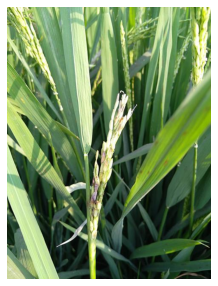

In [20]:
img_path = train_files[0]
img = PILImage.create(img_path)
print("File: ", img_path)
print("Size: ", img.size)
img.show()

New size:  (96, 128)


<AxesSubplot:>

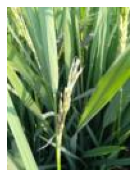

In [21]:
dest = Path('temp_img')
resize_image(img_path.name, # name of the file
             dest=dest,     # directory where to put resized, it recreates dir structure
             src=img_path.parent, # directory where to look for the source file
             max_size=128)
img = PILImage.create(dest/img_path.name)
print("New size: ", img.size)
img.show()


In [22]:
# resize all files in the folder

In [23]:
train_path_small = Path('train_x256')

In [24]:
%%time
# Resize all images so the max dimension is 256. We still use resizing on the fly later to make sure batches have all tensors of the same length 
# during training and inference
resize_images(train_path, dest=train_path_small, max_size=256, recurse=True)

CPU times: user 7.02 s, sys: 2.2 s, total: 9.22 s
Wall time: 57.2 s


## 2.1 Rerun baseline on resized images

In [55]:
%%time
learn, dls = train(train_path_small, "resnet26d", 
                   Resize(256, method='squish'),  # changed scale to 256 to match resized
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.801833,1.386955,0.442095,00:25


epoch,train_loss,valid_loss,error_rate,time
0,1.185072,0.869515,0.297934,00:30
1,0.796762,0.534007,0.173474,00:31
2,0.575969,0.414579,0.127343,00:32


CPU times: user 1min 27s, sys: 24.3 s, total: 1min 52s
Wall time: 2min 1s


On paperspace:
* overall duration: 2min 1sec
* per epoch: 30sec 🟢 (10 sec faster compared to the baseline on raw)
* err rate: 0.127 (just slightlyh= higher)

Utilisation of 
* GPU 60-70%
* GPU memory ~50%
* CPU  200%

# 3. Move to ConvxNet

In [27]:
%%time
# Note: Jeremy uses Resize(192,...) but it didn't change runtime, so I kept it on 256

learn, dls = train(train_path_small, "convnext_small.fb_in22k", # convnext_small_in22k is not available anymore
                   Resize(256, method='squish'),  # changed scale to 256 to match resized
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.259814,0.806145,0.254685,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.680516,0.543542,0.178760,02:22
1,0.408593,0.232462,0.074483,02:22
2,0.219434,0.177844,0.058145,02:22


CPU times: user 6min 9s, sys: 2min 3s, total: 8min 12s
Wall time: 8min 29s


On paperspace:
* overall duration: 8min 26sec
* per epoch: 2min 22sec  🟡 (x4 longer compared to resnet)
* err rate: 0.058145     🟢 (down from 0.14)

Utilisation of 
* GPU 100%
* GPU memory ~20-50%
* CPU  250%

Question: why it took 50sec in the Jeremy's version and 2.5min for me? Is model version significantly different?

# 4. Experiments with resizing

## 4.1 square 192 + squish

In [29]:
%%time
learn, dls = train(train_path_small, "convnext_small.fb_in22k", # convnext_small_in22k is not available anymore
                   Resize(192, method='squish'),  # changed to 192 from 256 as Jeremy did
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.228306,0.837202,0.258049,01:18


epoch,train_loss,valid_loss,error_rate,time
0,0.658110,0.491766,0.148486,02:21
1,0.440004,0.232551,0.073522,02:21
2,0.237111,0.190663,0.058145,02:22


CPU times: user 6min 10s, sys: 2min 2s, total: 8min 12s
Wall time: 8min 27s


On paperspace:
* overall duration: 8min 27sec
* per epoch: 2min 21sec
* err rate: 0.0581455 (stays the same as for 256)

## 4.2 square 192 + crop

By default it pad_method is reflection

In [30]:
%%time
learn, dls = train(train_path_small, "convnext_small.fb_in22k", # convnext_small_in22k is not available anymore
                   Resize(192),
                   aug_transforms(size=128, min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.294504,0.769939,0.238827,01:18


epoch,train_loss,valid_loss,error_rate,time
0,0.768819,0.566173,0.184527,02:20
1,0.453724,0.261444,0.083614,02:21
2,0.274592,0.197696,0.060067,02:20


CPU times: user 6min 7s, sys: 2min 2s, total: 8min 9s
Wall time: 8min 23s


On paperspace:
* overall duration: 8min 23
* per epoch: 2min 21sec
* err rate: 0.06 🟡 (slihgtly increased compared to squish)

## 4.3 keep proportions + crop + pad

In [57]:
prop = 2/3
new_height = int(prop * 256)
new_width = int(prop * 192)
print(f"Resize for batch augmentation to ({new_height},{new_width})")

Resize for batch augmentation to (170,128)


In [58]:
%%time
learn, dls = train(train_path_small, "convnext_small.fb_in22k", 
                   Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),  
                   aug_transforms(size=(new_height, new_width), min_scale=0.75), 
                   3)

epoch,train_loss,valid_loss,error_rate,time
0,1.287327,0.820664,0.258530,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.715515,0.456110,0.144161,03:01


KeyboardInterrupt: 

On paperspace:
* overall duration: 10min 48 sec
* per epoch: 03:02 🟡
* err rate: 0.055  🟢

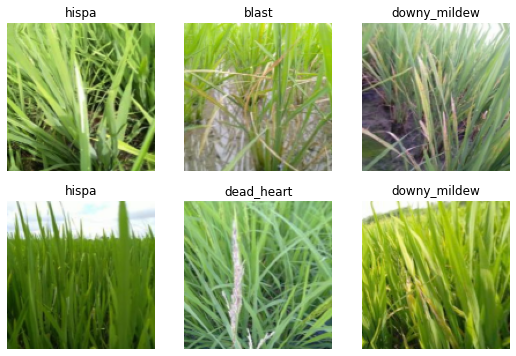

In [59]:
dls.show_batch(max_n=6)

# 5. TTA on validation set

In [60]:
# get validation data loader from leraner 
# It uses 20% of train data as specified in `train` function above
validation_dl = learn.dls.valid

In [61]:
preds, targs = learn.get_preds(dl=validation_dl)

In [62]:
print("Error rate on validation set without TTA", error_rate(preds, targs))

Error rate on validation set without TTA TensorBase(0.1283)


In [63]:
tta_preds, _ = learn.tta(dl=validation_dl)
print("Error rate on validation set without TTA", error_rate(tta_preds, targs))

Error rate on validation set without TTA TensorBase(0.1043)


# 6. Final model for submission
* use original images as an input instead of resized to 256
* keep proportions and use padding with zers (as best config)
* increase number of epochs

In [66]:
## 6.1 train

In [ ]:
%%time
learn_final, _ = train(train_path, "convnext_small.fb_in22k", 
                       Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), 
                       batch=aug_transforms(size=(256, 192), min_scale=0.75), 
                       12)

In [ ]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
tta_preds,targs = learn_final.tta(dl=learn_final.dls.valid)
print("Error rate for the final model with TTA:", error_rate(tta_preds, targs))

## 6.2 Generate scores for submission

In [ ]:
test_files = get_image_files( path / 'test_images').sorted()
test_dl = learn_final.dls.test_dl(test_files)

In [ ]:
predicted_idxs,_ = learn_final.tta(dl=test_dl)

In [ ]:
category_names = learn_final.dls.vocab
category_names

In [ ]:
subm_df = pd.read_csv(path / 'sample_submission.csv')

In [ ]:
subm_df['label'] = category_names[predicted_idxs.numpy()]

In [ ]:
assert subm_df["label"].isnull().sum() == 0

In [ ]:
subm_df.to_csv('subm_p2.csv', index=False)
!head subm.csv

In [ ]:
if not is_kaggle:
    from kaggle import api
    api.competition_submit_cli('subm_p2.csv', 'part2: convnext_small.fb_in22k (256, 192) TTA', COMPETITION_NAME)

# Push notebook to Kaggle

In [ ]:
if not is_kaggle:
    push_notebook('stware', 'paddy-02-convnext-resize-tta',
                  title='Paddy: 02 convnext + resize + tta',
                  file='01-baseline.ipynb',
                  competition=COMPETITION_NAME, private=False, gpu=True,  internet=True)